In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.cm as cm
import seaborn as sns
import statsmodels.api as sm

from matplotlib.ticker import PercentFormatter

In [2]:
#Load Data
dataset = pd.read_csv(r'../../data/processed/charity_main_cleaned.csv')
la_2025_asset_summary = pd.read_csv(r'../../data/processed/la_2025_asset_summary.csv')
population_summary = pd.read_csv(r'../../data/processed/population_summary_by_la.csv')

C:\Users\User\AppData\Local\Temp\ipykernel_33196\696023224.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(r'../../data/processed/charity_main_cleaned.csv')


In [3]:
# Define function to get financial year
def get_financial_year(date):
    if pd.isna(date):
        return np.nan
    return date.year if date.month >= 4 else date.year - 1

# --- ensure dates are in datetime ---
dataset['date_of_registration'] = pd.to_datetime(dataset['date_of_registration'], errors='coerce')
dataset['date_of_removal'] = pd.to_datetime(dataset['date_of_removal'], errors='coerce')

dataset['registration_year'] = dataset['date_of_registration'].dt.to_period('Y')
dataset['removal_year'] = dataset['date_of_removal'].dt.to_period('Y')

dataset['registration_month'] = dataset['date_of_registration'].dt.to_period('M')
dataset['removal_month'] = dataset['date_of_removal'].dt.to_period('M')

dataset['registration_fy'] = dataset['date_of_registration'].apply(get_financial_year)
dataset['removal_fy'] = dataset['date_of_removal'].apply(get_financial_year)

In [ ]:
# Count per financial year
registered_by_fy = dataset['registration_fy'].value_counts().sort_index()
removed_by_fy = dataset['removal_fy'].value_counts().sort_index()

# Filter to 2015–2024 financial years
registered_by_fy = registered_by_fy[(registered_by_fy.index >= 2015) & (registered_by_fy.index <= 2024)]
removed_by_fy = removed_by_fy[(removed_by_fy.index >= 2015) & (removed_by_fy.index <= 2024)]

# Print summary
print(f'Total number of charity data: {dataset["charity_status"].count():,}')
print(f"Total number of charities removed: {removed_by_fy.sum():,}")
print("Number of charities removed per FY (April–March):")
for year, count in removed_by_fy.items():
    print(f"FY {year}: {count:,}")

# Plot both lines
plt.figure(figsize=(10, 5))
plt.plot(registered_by_fy.index, registered_by_fy.values, marker='s', linestyle='--', color='#ff7f0e', label='Registered')
plt.plot(removed_by_fy.index, removed_by_fy.values, marker='o', linestyle='-', color='#1f77b4', label='Removed')

plt.title('Charities Registered vs Removed Per Financial Year (2015–2024)')
plt.xlabel('Financial Year')
plt.ylabel('Number of Charities')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(removed_by_fy.index.astype(int), [str(int(y)) for y in removed_by_fy.index], rotation=45)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.show()

In [ ]:
# Count per month
removed_by_month = dataset['removal_month'].value_counts().sort_index()
registered_by_month = dataset['registration_month'].value_counts().sort_index()

# Filter to 2015–2024
removed_by_month = removed_by_month[(removed_by_month.index >= pd.Period('2015-01')) & (removed_by_month.index <= pd.Period('2024-12'))]
registered_by_month = registered_by_month[(registered_by_month.index >= pd.Period('2015-01')) & (registered_by_month.index <= pd.Period('2024-12'))]

# Align indices
all_months = pd.period_range(start='2015-01', end='2024-12', freq='M')
removed_by_month = removed_by_month.reindex(all_months, fill_value=0)
registered_by_month = registered_by_month.reindex(all_months, fill_value=0)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(registered_by_month.index.to_timestamp(), registered_by_month.values, marker='s', linestyle='--', color='#ff7f0e', label='Registered')
plt.plot(removed_by_month.index.to_timestamp(), removed_by_month.values, marker='o', linestyle='-', color='#1f77b4', label='Removed')
plt.title('Charities Registered vs Removed Per Month (2015–2024)')
plt.xlabel('Month')
plt.ylabel('Number of Charities')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.show()


In [ ]:
# Filter monthly registration and removal data from 2014 to 2024 for calculation
registration_monthly = dataset['date_of_registration'].dropna().dt.to_period('M').value_counts().sort_index()
removal_monthly = dataset['date_of_removal'].dropna().dt.to_period('M').value_counts().sort_index()

# Ensure full monthly range for consistent plotting and rolling calculations
full_months = pd.period_range(start='2014-01', end='2024-12', freq='M')
registration_monthly = registration_monthly.reindex(full_months, fill_value=0)
removal_monthly = removal_monthly.reindex(full_months, fill_value=0)

# Calculate moving averages
windows = [3, 6, 12]
registration_ma = {f"{w}-month MA": registration_monthly.rolling(window=w, min_periods=1).mean() for w in windows}
removal_ma = {f"{w}-month MA": removal_monthly.rolling(window=w, min_periods=1).mean() for w in windows}

# Prepare plotting only from 2015 onwards
plot_months = registration_monthly.index[registration_monthly.index >= '2015-01']

import matplotlib.ticker as mticker
fig, axs = plt.subplots(len(windows), 1, figsize=(14, 14), sharex=True)

for ax, w in zip(axs, windows):
    reg_series = registration_ma[f"{w}-month MA"].loc[plot_months]
    rem_series = removal_ma[f"{w}-month MA"].loc[plot_months]

    ax.plot(reg_series.index.to_timestamp(), reg_series.values, linestyle='--', label='Registered', color='tab:orange')
    ax.plot(rem_series.index.to_timestamp(), rem_series.values, linestyle='-', label='Removed', color='tab:blue')
    ax.set_title(f"Monthly Charity Registrations and Removals – {w}-Month Moving Average")
    ax.set_ylabel("Charities")
    ax.grid(True)
    ax.legend()

axs[-1].set_xlabel("Month")
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [ ]:
# 2015-2024 window
year_mask = (
    (dataset['date_of_registration'].dt.year.between(2015, 2024)) |
    (dataset['date_of_removal'].dt.year      .between(2015, 2024))
)
# --- rows where income is missing AND in the time window ---
missing_income_rows = dataset[dataset['latest_income'].isna() & year_mask]

# how many
count_missing = len(missing_income_rows)
print(f"Missing-income charities (2015-2024 window): {count_missing:,}")

# Apply to create financial year column (prioritise registration over removal if available)
missing_income_rows = missing_income_rows.copy()
missing_income_rows['financial_year'] = missing_income_rows['date_of_registration'].apply(get_financial_year)
missing_income_rows['financial_year'] = missing_income_rows['financial_year'].fillna(
    missing_income_rows['date_of_removal'].apply(get_financial_year)
)
# Drop NaNs and count per year
fy_counts = missing_income_rows['financial_year'].dropna().astype(int).value_counts().sort_index()

# Keep only financial years from 2015 to 2024
fy_counts = fy_counts[(fy_counts.index >= 2015) & (fy_counts.index <= 2024)]

print("Count of missing-income charities per financial year (2015–2024):")
print(fy_counts)

In [ ]:
# Extract financial year from registration date (FY starts in April)
dataset['registration_fy'] = dataset['date_of_registration'].apply(
    lambda x: x.year if x.month < 4 else x.year + 1
)

# Filter to years 2015–2022
fy_counts = (
    dataset[dataset['registration_fy'].between(2015, 2022)]
    .groupby(['registration_fy', 'size_category'])
    .size()
    .unstack(fill_value=0)
)

# Plot
ax = fy_counts.plot(kind='bar', figsize=(12, 6), color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Number of Registered Charities by Size per Financial Year (2015–2022)')
plt.xlabel('Financial Year')
plt.ylabel('Number of Charities')
plt.xticks(rotation=45)
plt.legend(title='Size Category')
plt.grid(axis='y')
plt.tight_layout()
plt.show()



In [ ]:
# Group by financial year and size category
registered_fy = (
    dataset.dropna(subset=['registration_fy', 'size_category'])
    .groupby(['registration_fy', 'size_category'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

removed_fy = (
    dataset.dropna(subset=['removal_fy', 'size_category'])
    .groupby(['removal_fy', 'size_category'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# Filter to FY 2015–2022 for plotting
registered_fy = registered_fy[(registered_fy.index >= 2015) & (registered_fy.index <= 2022)]
removed_fy = removed_fy[(removed_fy.index >= 2015) & (removed_fy.index <= 2022)]

# Define consistent colours for size categories
size_colours = {
    'Small': '#1f77b4',
    'Medium': '#ff7f0e',
    'Large': '#2ca02c'
}

# Plotting
plt.figure(figsize=(12, 6))

# Registered (dashed lines)
for size in ['Small', 'Medium', 'Large']:
    if size in registered_fy.columns:
        plt.plot(
            registered_fy.index,
            registered_fy[size],
            linestyle='--',
            marker='o',
            label=f'Registered ({size})',
            color=size_colours[size]
        )

# Removed (solid lines)
for size in ['Small', 'Medium', 'Large']:
    if size in removed_fy.columns:
        plt.plot(
            removed_fy.index,
            removed_fy[size],
            linestyle='-',
            marker='s',
            label=f'Removed ({size})',
            color=size_colours[size]
        )

plt.title('Charity Registrations and Removals by Size per Financial Year (2015–2022)')
plt.xlabel('Financial Year')
plt.ylabel('Number of Charities')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.show()

In [ ]:
# Define financial year range
financial_years = list(range(2015, 2023))  # Start from 2015 as we need previous year for denominator

# Prepare percentage change summary
data_summary = []

for fy in financial_years:
    for size in ['Small', 'Medium', 'Large']:
        # Population at start of FY = registered before FY-1 and not removed before or in FY-1
        active_start_fy = dataset[
            (dataset['size_category'] == size) &
            (dataset['registration_fy'] <= fy - 1) &
            ((dataset['removal_fy'].isna()) | (dataset['removal_fy'] > fy - 1))
        ].shape[0]

        registered = dataset[(dataset['size_category'] == size) & (dataset['registration_fy'] == fy)].shape[0]
        removed = dataset[(dataset['size_category'] == size) & (dataset['removal_fy'] == fy)].shape[0]

        reg_pct = (registered / active_start_fy) * 100 if active_start_fy > 0 else None
        rem_pct = (removed / active_start_fy) * 100 if active_start_fy > 0 else None

        data_summary.append({
            'Financial Year': fy,
            'Size': size,
            'Registered %': reg_pct,
            'Removed %': rem_pct
        })

# Convert to DataFrame
summary_df = pd.DataFrame(data_summary)

# Pivot for plotting
reg_pivot = summary_df.pivot(index='Financial Year', columns='Size', values='Registered %')
rem_pivot = summary_df.pivot(index='Financial Year', columns='Size', values='Removed %')

# Plot
plt.figure(figsize=(12, 6))
colors = {'Small': 'tab:blue', 'Medium': 'tab:orange', 'Large': 'tab:green'}

for size in ['Small', 'Medium', 'Large']:
    if size in reg_pivot.columns:
        plt.plot(reg_pivot.index, reg_pivot[size], linestyle='--', marker='o', color=colors[size], label=f'Registered ({size})')
    if size in rem_pivot.columns:
        plt.plot(rem_pivot.index, rem_pivot[size], linestyle='-', marker='s', color=colors[size], label=f'Removed ({size})')

plt.title("Charity Registration and Removal Rates by Size (FY 2015–2022)\n(% of Previous Year’s Population)")
plt.xlabel("Financial Year")
plt.ylabel("Rate (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter())
plt.show()


In [ ]:
# Define monthly period range
all_months = pd.period_range(start='2014-12', end='2022-12', freq='M')

# Ensure datetime columns and period columns exist
dataset['date_of_registration'] = pd.to_datetime(dataset['date_of_registration'], errors='coerce')
dataset['date_of_removal'] = pd.to_datetime(dataset['date_of_removal'], errors='coerce')
dataset['registration_month'] = dataset['date_of_registration'].dt.to_period('M')
dataset['removal_month'] = dataset['date_of_removal'].dt.to_period('M')

# Calculate registration and removal counts by size and month
registered_counts = (
    dataset[dataset['registration_month'].between('2015-01', '2024-12')]
    .groupby(['registration_month', 'size_category'])
    .size()
    .unstack(fill_value=0)
)

removed_counts = (
    dataset[dataset['removal_month'].between('2015-01', '2024-12')]
    .groupby(['removal_month', 'size_category'])
    .size()
    .unstack(fill_value=0)
)

# Calculate population at the start of each month
monthly_population = {}
for month in all_months[1:]:  # Start from 2015-01
    active = dataset[
        (dataset['registration_month'] <= month - 1) &
        ((dataset['removal_month'].isna()) | (dataset['removal_month'] > month - 1))
    ]
    counts = active['size_category'].value_counts().to_dict()
    monthly_population[month] = counts

population_df = pd.DataFrame(monthly_population).T.fillna(0).astype(int)
population_df.index.name = 'month'

# Calculate percentage
reg_pct = (registered_counts.div(population_df) * 100).dropna()
rem_pct = (removed_counts.div(population_df) * 100).dropna()

# Convert index for plotting
reg_pct.index = reg_pct.index.to_timestamp()
rem_pct.index = rem_pct.index.to_timestamp()

# Plotting
plt.figure(figsize=(14, 7))
colors = {'Small': 'tab:blue', 'Medium': 'tab:orange', 'Large': 'tab:green'}

for size in ['Small', 'Medium', 'Large']:
    if size in reg_pct.columns:
        plt.plot(reg_pct.index, reg_pct[size], linestyle='--', marker='o', color=colors[size], label=f'Registered ({size})')
    if size in rem_pct.columns:
        plt.plot(rem_pct.index, rem_pct[size], linestyle='-', marker='s', color=colors[size], label=f'Removed ({size})')

plt.title('Monthly Charity Registration and Removal Rates by Size (2015–2024)\n(% of Previous Month’s Population)')
plt.xlabel('Month')
plt.ylabel('Rate (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter())
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter registered and removed counts to only visualise from 2015
registered_counts_filtered = registered_counts[registered_counts.index >= '2015-01']
removed_counts_filtered = removed_counts[removed_counts.index >= '2015-01']

# Recompute moving averages for filtered data
ma_windows = [3, 6, 12]
ma_results_filtered = {}

for window in ma_windows:
    reg_ma = registered_counts_filtered.rolling(window=window, min_periods=1).mean()
    rem_ma = removed_counts_filtered.rolling(window=window, min_periods=1).mean()
    ma_results_filtered[f'{window}-month MA'] = (reg_ma, rem_ma)

# Plotting

size_colours = {
    'Small': '#1f77b4',
    'Medium': '#ff7f0e',
    'Large': '#2ca02c'
}

fig, axs = plt.subplots(len(ma_results_filtered), 1, figsize=(14, 12), sharex=True)

for ax, (label, (reg_ma, rem_ma)) in zip(axs, ma_results_filtered.items()):
    for size in ['Small', 'Medium', 'Large']:
        if size in reg_ma.columns:
            ax.plot(reg_ma.index.to_timestamp(), reg_ma[size], linestyle='--', marker='o',
                    label=f'Registered ({size})', color=size_colours[size])
        if size in rem_ma.columns:
            ax.plot(rem_ma.index.to_timestamp(), rem_ma[size], linestyle='-', marker='s',
                    label=f'Removed ({size})', color=size_colours[size])
    ax.set_title(f'Monthly Charity Registrations and Removals by Size – {label}')
    ax.set_ylabel('Number of Charities')
    ax.grid(True)
    ax.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

axs[-1].set_xlabel("Month")
plt.tight_layout()
plt.show()




In [ ]:
# Define range of months for calculation
all_months = pd.period_range(start='2015-01', end='2022-12', freq='M')
sizes = ['Small', 'Medium', 'Large']

# Create empty lists to store data
summary = []

# Loop through each month and size to compute metrics
for month in all_months[1:]:  # skip first to allow lookback
    prev_month = month - 1
    for size in sizes:
        # Population at the start of this month
        active_last_month = dataset[
            (dataset['size_category'] == size) &
            (dataset['registration_month'] <= prev_month) &
            ((dataset['removal_month'].isna()) | (dataset['removal_month'] > prev_month))
        ].shape[0]

        # Registrations and removals in current month
        registered = dataset[(dataset['size_category'] == size) & (dataset['registration_month'] == month)].shape[0]
        removed = dataset[(dataset['size_category'] == size) & (dataset['removal_month'] == month)].shape[0]

        # Calculate percentage
        reg_pct = (registered / active_last_month) * 100 if active_last_month > 0 else None
        rem_pct = (removed / active_last_month) * 100 if active_last_month > 0 else None

        summary.append({
            'Month': month.to_timestamp(),
            'Size': size,
            'Registered %': reg_pct,
            'Removed %': rem_pct
        })

# Reconstruct summary_df for plotting
summary_df = pd.DataFrame(summary)

# Pivot for plotting
reg_pivot = summary_df.pivot(index='Month', columns='Size', values='Registered %')
rem_pivot = summary_df.pivot(index='Month', columns='Size', values='Removed %')

# Combine into a single DataFrame with suffixes
combined_df = pd.concat([reg_pivot.add_suffix(' - Registered'), rem_pivot.add_suffix(' - Removed')], axis=1)

# Compute moving averages
ma_windows = [3, 6, 12]
ma_results = {f"{w}-month MA": combined_df.rolling(window=w, min_periods=1).mean() for w in ma_windows}

# Define colors for each size and action
size_colours = {
    'Small': '#1f77b4',
    'Medium': '#ff7f0e',
    'Large': '#2ca02c'
}
action_styles = {
    'Registered': '--',
    'Removed': '-'
}

# Plotting
fig, axs = plt.subplots(len(ma_results), 1, figsize=(14, 12), sharex=True)

for ax, (label, df) in zip(axs, ma_results.items()):
    for col in df.columns:
        size = col.split(' - ')[0]
        action = col.split(' - ')[1]
        ax.plot(df.index, df[col], label=col, color=size_colours[size], linestyle=action_styles[action])
    ax.set_title(f'Monthly Registration & Removal Rates – {label}')
    ax.set_ylabel('Rate (%)')
    ax.grid(True)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

axs[-1].set_xlabel("Month")
plt.tight_layout()

plt.show()


In [ ]:
# --- Calculate charity age at removal ---
dataset['age_at_removal'] = (
    dataset['date_of_removal'] - dataset['date_of_registration']
).dt.days // 365  # convert to approximate years

# --- Define age bins and labels ---
bins = [0, 10, 20, 30, 40, 50, float('inf')]
labels = ['0–10 yrs', '11–20 yrs', '21–30 yrs', '31–40 yrs', '41–50 yrs', '50+ yrs']
dataset['removal_age_group'] = pd.cut(dataset['age_at_removal'], bins=bins, labels=labels, right=False)

# --- Filter data to financial years of interest ---
filtered = dataset[dataset['removal_fy'].between(2015, 2024)]

# --- Group and count removals by FY and age group ---
removals_by_age_fy = (
    filtered.groupby(['removal_fy', 'removal_age_group'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# --- Plot ---
plt.figure(figsize=(14, 6))
for col in removals_by_age_fy.columns:
    plt.plot(removals_by_age_fy.index, removals_by_age_fy[col], marker='o', label=col)

plt.title('Removed Charities in the UK by Age at Removal (Financial Year)')
plt.xlabel('Financial Year')
plt.ylabel('Number of Removals')
plt.legend(title='Charity Age at Removal')
plt.grid(True)
plt.tight_layout()
plt.xticks(removals_by_age_fy.index)
plt.show()


In [ ]:
# Filter relevant years
filtered = dataset[dataset['removal_fy'].between(2015, 2024)].copy()

# Initialize dictionary for denominators
denominator_dict = {}

# Calculate active charities at start of each FY by age group
for fy in range(2015, 2025):
    active = dataset[
        (dataset['registration_fy'] <= fy - 1) &
        ((dataset['removal_fy'].isna()) | (dataset['removal_fy'] > fy - 1))
    ].copy()
    active['age'] = fy - active['registration_fy']
    active['removal_age_group'] = pd.cut(active['age'], bins=bins, labels=labels, right=False)
    denominator = active['removal_age_group'].value_counts().reindex(labels, fill_value=0)
    denominator_dict[fy] = denominator

# Build a DataFrame from the dictionary
denominator_df = pd.DataFrame(denominator_dict).T

# Count removals by FY and age group
removals_by_age_fy = (
    filtered.groupby(['removal_fy', 'removal_age_group'])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=labels, fill_value=0)
)

# Calculate removal rates as percentage of population at start of year
removal_rates = (removals_by_age_fy / denominator_df.loc[removals_by_age_fy.index]) * 100

# Plot
plt.figure(figsize=(14, 6))
for col in removal_rates.columns:
    plt.plot(removal_rates.index, removal_rates[col], marker='o', label=col)

plt.title('Removal Rates by Age Group (as % of Previous Year Population, FY 2015–2024)')
plt.xlabel('Financial Year')
plt.ylabel('Removal Rate (%)')
plt.legend(title='Charity Age at Removal')
plt.grid(True)
plt.tight_layout()
plt.xticks(removal_rates.index)
plt.show()

In [ ]:
# Step 4: Define monthly period for removal
dataset['removal_month'] = dataset['date_of_removal'].dt.to_period('M')
dataset['registration_month'] = dataset['date_of_registration'].dt.to_period('M')

# Step 5: Generate monthly population snapshot
all_months = pd.period_range(start='2014-12', end='2024-12', freq='M')  # Include 2014-12 for Jan 2015 calc

monthly_population = {}
for month in all_months[1:]:  # start from Jan 2015
    active = dataset[
        (dataset['registration_month'] <= month - 1) &
        ((dataset['removal_month'].isna()) | (dataset['removal_month'] > month - 1))
    ]
    monthly_population[month] = len(active)

population_df = pd.Series(monthly_population).to_frame(name='active_previous_month')

# Step 6: Group removals by month and age group
removal_counts = (
    dataset.dropna(subset=['removal_month', 'removal_age_group'])
    .groupby(['removal_month', 'removal_age_group'])
    .size()
    .unstack(fill_value=0)
)

# Step 7: Align index and calculate percentage
removal_rates = removal_counts.div(population_df['active_previous_month'], axis=0) * 100

# Filter for visualisation range
removal_rates = removal_rates[(removal_rates.index >= '2015-01') & (removal_rates.index <= '2024-12')]

# Step 8: Plot
plt.figure(figsize=(14, 7))
for col in removal_rates.columns:
    plt.plot(removal_rates.index.to_timestamp(), removal_rates[col], label=col, marker='o')

plt.title("Monthly % Removal by Charity Age Group (Normalised by Previous Month's Population)")
plt.xlabel("Month")
plt.ylabel("Removal Rate (%)")
plt.legend(title='Age at Removal')
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
# Group and count removals by month and age group
monthly_removals_by_age = (
    dataset[dataset['removal_month'].between('2015-01', '2024-12')]
    .groupby(['removal_month', 'removal_age_group'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)
# Compute moving averages
ma_windows = [3, 6, 12]
ma_results = {f'{w}-month MA': monthly_removals_by_age.rolling(window=w, min_periods=1).mean() for w in ma_windows}

# Convert index to timestamp for plotting
for k in ma_results:
    ma_results[k].index = ma_results[k].index.to_timestamp()

# Plotting
fig, axs = plt.subplots(len(ma_results), 1, figsize=(14, 12), sharex=True)

for ax, (label, df) in zip(axs, ma_results.items()):
    for col in df.columns:
        ax.plot(df.index, df[col], label=col, marker='o')
    ax.set_title(f'Removed Charities by Age Group – {label}')
    ax.set_ylabel('Number of Removals')
    ax.grid(True)
    ax.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')

axs[-1].set_xlabel("Month")
plt.tight_layout()
plt.show()

In [ ]:
# Count removals per month per age group
monthly_counts = (
    dataset.dropna(subset=['removal_month', 'removal_age_group'])
    .groupby(['removal_month', 'removal_age_group'])
    .size()
    .unstack(fill_value=0)
)

# Calculate total active charities at the start of each month
# A charity is active if it was registered before the month and not yet removed
all_months = pd.period_range(dataset['removal_month'].min(), dataset['removal_month'].max(), freq='M')
active_counts = []

for month in all_months:
    cutoff = month.start_time
    active = dataset[
        (dataset['date_of_registration'] <= cutoff) &
        ((dataset['date_of_removal'].isna()) | (dataset['date_of_removal'] > cutoff))
    ]
    active_counts.append((month, active.shape[0]))

active_df = pd.DataFrame(active_counts, columns=['Month', 'Active'])
active_df.set_index('Month', inplace=True)

# Compute percentage removal rate per month
removal_rates = monthly_counts.div(active_df['Active'], axis=0) * 100

# Compute moving averages using all data, but plot only 2015–2024
removal_rates.index = removal_rates.index.to_timestamp()
ma_windows = [3, 6, 12]
ma_results = {
    f"{w}-month MA": removal_rates.rolling(window=w, min_periods=1).mean()
    for w in ma_windows
}

# Filter to display only 2015–2024
plot_range = (removal_rates.index >= '2015-01') & (removal_rates.index <= '2024-12')

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(14, 14), sharex=True)

for ax, (label, df) in zip(axs, ma_results.items()):
    for col in df.columns:
        ax.plot(df.index[plot_range], df[col][plot_range], label=col, marker='o')
    ax.set_title(f'Removal Rate by Age Group – {label}')
    ax.set_ylabel('Removal Rate (%)')
    ax.grid(True)
    ax.legend(title='Age at Removal')

axs[-1].set_xlabel("Month")
plt.tight_layout()
plt.show()

In [4]:
# Step 4: Filter by financial year
filtered = dataset[dataset['removal_fy'].between(2015, 2024)].copy()

# Step 5: Group by financial year and classification
category_trend = (
    filtered
    .groupby(['removal_fy', 'classification_description'])
    .size()
    .reset_index(name='count')
)
# Pivot: years as index, categories as columns
category_timeline = (
    category_trend
    .pivot(index='removal_fy', columns='classification_description', values='count')
    .fillna(0)
)

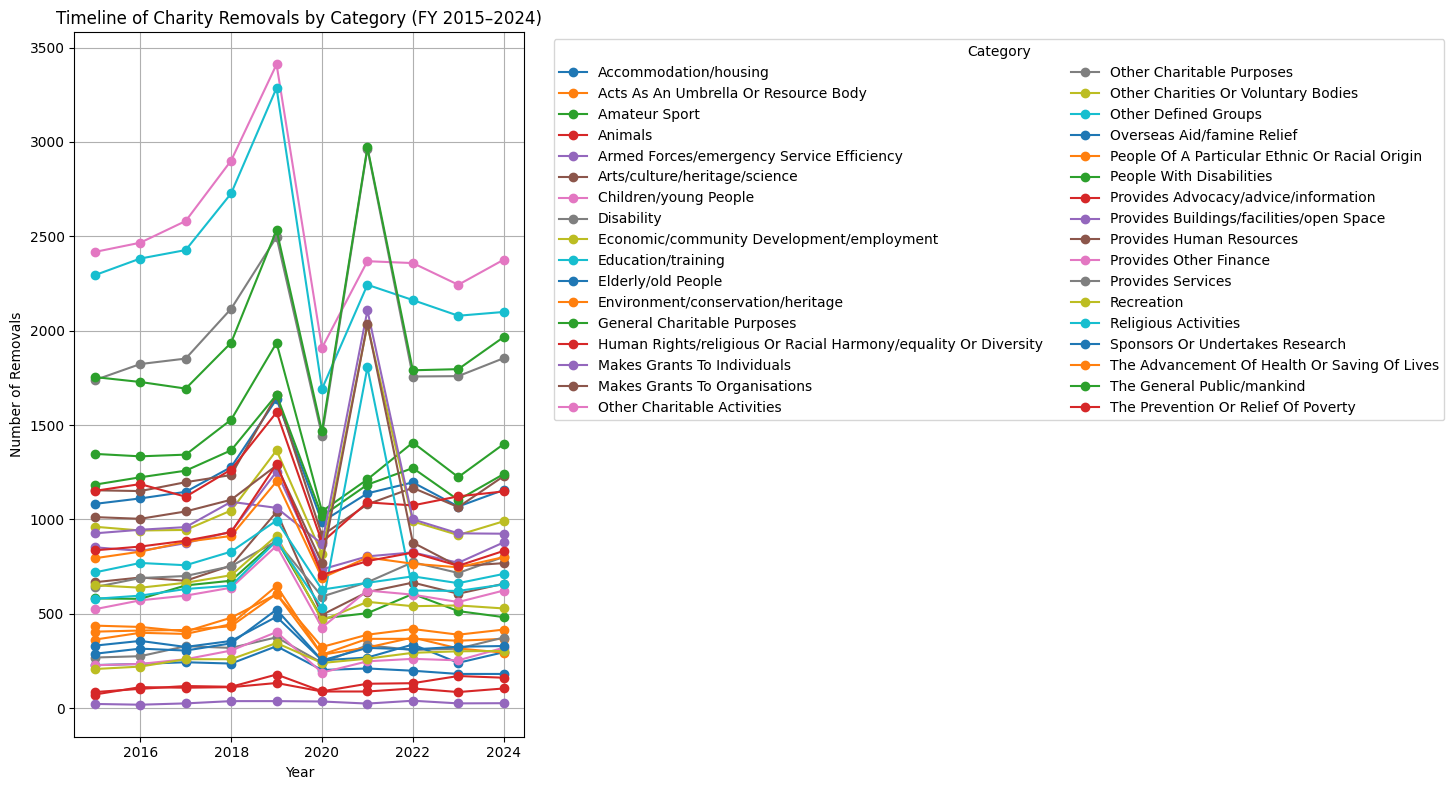

In [5]:
# Number of categories
num_lines = len(category_timeline.columns)

# Plot with colours
plt.figure(figsize=(15, 8))
for i, col in enumerate(category_timeline.columns):
    plt.plot(
        category_timeline.index,
        category_timeline[col],
        marker='o',
        label=col,
    )

plt.title("Timeline of Charity Removals by Category (FY 2015–2024)")
plt.xlabel("Year")
plt.ylabel("Number of Removals")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
top5_per_year = (
    category_trend
    .sort_values(['removal_fy', 'count'], ascending=[True, False])
    .groupby('removal_fy')
    .head(5)
)
plt.figure(figsize=(12, 6))
sns.barplot(data=top5_per_year, x='removal_fy', y='count', hue='classification_description')

plt.title("Top 5 Removed Charity Categories by Financial Year")
plt.xlabel("Year")
plt.ylabel("Number of Removals")
plt.xticks(rotation=45)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# ✅ Step 1: Get top 15 categories in 2022
top15_2022_categories = (
    category_trend[category_trend['removal_fy'] == 2022]
    .sort_values(by='count', ascending=False)
    .head(15)['classification_description']
    .tolist()
)

# ✅ Step 2: Pivot timeline table
category_timeline = (
    category_trend
    .pivot(index='removal_fy', columns='classification_description', values='count')
    .fillna(0)
)

# ✅ Step 3: Filter to only top 10 categories
top15_timeline = category_timeline[top15_2022_categories]

# ✅ Step 4: Plot
plt.figure(figsize=(14, 7))
for category in top15_timeline.columns:
    plt.plot(top15_timeline.index, top15_timeline[category], marker='o', label=category)

plt.title("Top 15 Charity Removals (FY 2022) – Trends Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Removals")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
filtered = dataset[dataset['removal_fy'].between(2015, 2024)]

# Step 2: Plot general top 10 per size category
for size in ['Small', 'Medium', 'Large']:
    size_df = filtered[filtered['size_category'] == size]

    # ✅ Top 10 categories across all years
    top10 = (
        size_df.groupby('classification_description')
        .size()
        .sort_values(ascending=False)
        .head(15)
        .index
    )

    # ✅ Build trend table
    timeline = (
        size_df[size_df['classification_description'].isin(top10)]
        .groupby(['removal_fy', 'classification_description'])
        .size()
        .reset_index(name='count')
        .pivot(index='removal_fy', columns='classification_description', values='count')
        .fillna(0)
    )

    # Filter the timeline to only include years up to 2022
    timeline_trimmed = timeline[timeline.index <= 2022]

    # Re-plotting for one size category as example (e.g., Small)
    plt.figure(figsize=(14, 7))
    for col in timeline_trimmed.columns:
        plt.plot(timeline_trimmed.index, timeline_trimmed[col], marker='o', label=col)

    plt.title(f"Top 15 Removed Categories Over Time – {size} Charities (FY 2015–2022)")
    plt.xlabel("Year")
    plt.ylabel("Number of Removals")
    plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# Step 2: Create monthly population snapshots by category
all_months = pd.period_range(start='2014-01', end='2024-12', freq='M')
population_snapshots = {}

for month in all_months:
    active = dataset[
        (dataset['registration_month'] <= month - 1) &
        ((dataset['removal_month'].isna()) | (dataset['removal_month'] > month - 1))
    ]
    population_snapshots[month] = active.groupby('classification_description').size()

population_df = pd.DataFrame(population_snapshots).T.fillna(0)

# Step 3: Clean valid removals
valid_removals = dataset.dropna(subset=['removal_month', 'classification_description'])

# Step 4: Mandatory category
must_include = "Provides Buildings/facilities/open Space"

# Step 5: Generate results for each size group
results = {}

for size in ['Small', 'Medium', 'Large']:
    size_df = valid_removals[valid_removals['size_category'] == size]

    # Get top 5 (excluding mandatory)
    top5 = (
        size_df['classification_description']
        .value_counts()
        .drop(labels=[must_include], errors='ignore')
        .head(5)
        .index
    )

    selected_categories = list(top5)
    if must_include in size_df['classification_description'].unique():
        selected_categories.append(must_include)

    # Monthly removal counts
    monthly_counts = (
        size_df[size_df['classification_description'].isin(selected_categories)]
        .groupby(['removal_month', 'classification_description'])
        .size()
        .unstack(fill_value=0)
        .sort_index()
    )

    # Monthly active denominator
    denom_df = population_df[selected_categories].reindex(monthly_counts.index)
    pct_change = monthly_counts.div(denom_df) * 100
    pct_change_trimmed = pct_change[pct_change.index >= pd.Period('2015-01')]

    results[size] = pct_change_trimmed

# Step 6: Plot
fig, axs = plt.subplots(3, 1, figsize=(14, 18), sharex=True)

for ax, (size, df) in zip(axs, results.items()):
    for col in df.columns:
        ax.plot(df.index.to_timestamp(), df[col], label=col)
    ax.set_title(f"{size} Charities – Monthly Removal Rate (% of Previous Month's Population)")
    ax.set_ylabel("Removal Rate (%)")
    ax.grid(True)
    ax.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')

axs[-1].set_xlabel("Month")
plt.tight_layout()
plt.show()



In [ ]:
# Step 1: Standardise IDs and calculate periods
dataset['registered_charity_number'] = dataset['registered_charity_number'].astype(str).str.zfill(6)
df_category['registered_charity_number'] = df_category['registered_charity_number'].astype(str).str.zfill(6)

dataset['registration_month'] = pd.to_datetime(dataset['date_of_registration'], errors='coerce').dt.to_period('M')
dataset['removal_month'] = pd.to_datetime(dataset['date_of_removal'], errors='coerce').dt.to_period('M')

# Step 2: Merge BEFORE filtering
merged = pd.merge(dataset, df_category, on='registered_charity_number', how='inner')

# Step 3: Build monthly population by size category
all_months = pd.period_range(start='2014-01', end='2024-12', freq='M')
size_categories = ['Small', 'Medium', 'Large']
population_records = []

for month in all_months:
    for size in size_categories:
        active = merged[
            (merged['size_category'] == size) &
            (merged['registration_month'] <= (month - 1)) &
            ((merged['removal_month'].isna()) | (merged['removal_month'] > (month - 1)))
        ]
        population_records.append({'month': month, 'size': size, 'active_prev_month': len(active)})

population_df = pd.DataFrame(population_records).pivot(index='month', columns='size', values='active_prev_month')

# Step 4: Define mandatory category
must_include = "Provides Buildings/facilities/open Space"

# Step 5: Loop by size category
for size in size_categories:
    size_df = merged[merged['size_category'] == size]

    # Top 5 categories + mandatory
    top5 = (
        size_df['classification_description']
        .value_counts()
        .drop(labels=[must_include], errors='ignore')
        .head(5)
        .index
    )

    selected_categories = list(top5)
    if must_include in size_df['classification_description'].unique():
        selected_categories.append(must_include)

    # Monthly removal counts for selected categories
    monthly_counts = (
        size_df[size_df['classification_description'].isin(selected_categories)]
        .groupby(['removal_month', 'classification_description'])
        .size()
        .unstack(fill_value=0)
        .sort_index()
    )

    # Divide by monthly population for percentage removal
    monthly_rates = monthly_counts.div(population_df[size], axis=0) * 100

    # Moving averages and plotting (only from 2015 for display)
    for window in [3, 6, 12]:
        ma = monthly_rates.rolling(window=window, min_periods=1).mean()
        ma_filtered = ma[ma.index >= pd.Period('2015-01', freq='M')]

        plt.figure(figsize=(14, 6))
        for col in ma_filtered.columns:
            plt.plot(ma_filtered.index.to_timestamp(), ma_filtered[col], label=col)

        plt.title(f"{size} Charities – {window}-Month Moving Avg of Removals (% of Population)\nTop Categories incl. '{must_include}'")
        plt.xlabel("Month")
        plt.ylabel("Removal Rate (% of Prev Month Population)")
        plt.grid(True)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Category")
        plt.tight_layout()
        plt.show()


In [ ]:
# Merge
merged_reg = pd.merge(dataset, df_category, on='registered_charity_number', how='inner')
filtered_reg = merged_reg[merged_reg['registration_fy'].between(2015, 2024)]

# Top 10 categories overall
top10_reg = (
    filtered_reg.groupby('classification_description')
    .size()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# Timeline of top 10
reg_timeline = (
    filtered_reg[filtered_reg['classification_description'].isin(top10_reg)]
    .groupby(['registration_fy', 'classification_description'])
    .size()
    .reset_index(name='count')
    .pivot(index='registration_fy', columns='classification_description', values='count')
    .fillna(0)
)
reg_timeline = reg_timeline[reg_timeline.index <= 2022]  # Optional: limit to FY2015–2022

# Plot
plt.figure(figsize=(14, 7))
for col in reg_timeline.columns:
    plt.plot(reg_timeline.index, reg_timeline[col], marker='o', label=col)

plt.title("Top 10 Registered Charity Categories Over Time (FY 2015–2022)")
plt.xlabel("Financial Year")
plt.ylabel("Number of Registrations")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
dataset['date_of_removal'] = pd.to_datetime(dataset['date_of_removal'], errors='coerce')
dataset['removal_year'] = dataset['date_of_removal'].dt.year

removed = dataset[dataset['removal_year'].notnull() & dataset['local_authority'].notnull()]

removed_by_year_la = (
    removed
    .groupby(['local_authority', 'removal_year'])
    .size()
    .unstack(fill_value=0)
    .sort_index(axis=1)
)

# ✅ Keep only years 2015–2024
years = list(range(2015, 2025))
removed_by_year_la = removed_by_year_la[removed_by_year_la.columns.intersection(years)]

# ✅ Recalculate total and sort
removed_by_year_la['Total'] = removed_by_year_la.sum(axis=1)
removed_by_year_la = removed_by_year_la.sort_values(by='Total', ascending=False)

print("Removed Charities per Year per Local Authority (2015–2024):")
print(removed_by_year_la.head(10))


In [ ]:
# Step 1: Define year range
years = list(range(2015, 2025))

# Step 2: Calculate percentage change across years
removed_pct_change = removed_by_year_la[years].pct_change(axis=1) * 100

# Step 3: Round for readability
removed_pct_change = removed_pct_change.round(2)
removed_pct_change

In [ ]:
# Already sorted by total, so just keep top 50
top_50_removed = removed_by_year_la.head(15).drop(columns='Total')
# This is now a DataFrame of shape (50, 10) with years 2015–2024

removed_pct_change = top_50_removed.pct_change(axis=1) * 100
removed_pct_change = removed_pct_change.round(2)

removed_pct_change_long = (
    removed_pct_change
    .reset_index()
    .melt(id_vars='local_authority', var_name='year', value_name='pct_change')
)
removed_pct_change

In [ ]:
def highlight_top2_bottom2(row):
    # Ignore NaNs
    sorted_vals = row.dropna().sort_values(ascending=False)
    top2 = sorted_vals[:2].values
    bottom2 = sorted_vals[-2:].values

    return [
        'color: red; font-weight: bold' if val in top2
        else 'color: blue; font-weight: bold' if val in bottom2
        else ''
        for val in row
    ]
# Make sure columns are int
removed_pct_change.columns = removed_pct_change.columns.astype(int)

# Drop 2015 column
removed_pct_change_clean = removed_pct_change.drop(columns=[2015])

# Apply styling
styled_wide = removed_pct_change_clean.style.apply(highlight_top2_bottom2, axis=1)
styled_wide

In [ ]:
# 1. Drop 'Total' column if exists
yearly_data = removed_by_year_la.drop(columns='Total')

# 2. General trend: total removals per year (across all councils)
general_trend = yearly_data.sum(axis=0)

# 3. % change in general trend year-on-year
general_pct_change = general_trend.pct_change() * 100
general_pct_change = general_pct_change.round(2)
print("📈 General % Change in Charity Removals per Year:")
print(general_pct_change)
# 4. Get top 15 councils
top15 = removed_by_year_la.head(15).drop(columns='Total')

# 5. Calculate % change for each
top15_pct_change = top15.pct_change(axis=1) * 100
top15_pct_change = top15_pct_change.round(2)
# 6. Subtract general trend to get deviation
deviation_from_general = top15_pct_change.subtract(general_pct_change, axis=1)
strong_deviations = deviation_from_general[deviation_from_general.abs() > 40]

print("📌 Strong Deviations (>±40% from general trend):")
print(strong_deviations.dropna(how='all'))


In [ ]:
# Use already-merged and filtered dataset
for size in ['Small', 'Medium', 'Large']:
    size_df = filtered_reg[filtered_reg['size_category'] == size]

    top10_size = (
        size_df.groupby('classification_description')
        .size()
        .sort_values(ascending=False)
        .head(10)
        .index
    )

    size_timeline = (
        size_df[size_df['classification_description'].isin(top10_size)]
        .groupby(['registration_year', 'classification_description'])
        .size()
        .reset_index(name='count')
        .pivot(index='registration_year', columns='classification_description', values='count')
        .fillna(0)
    )

    plt.figure(figsize=(14, 7))
    for col in size_timeline.columns:
        plt.plot(size_timeline.index, size_timeline[col], marker='o', label=col)

    plt.title(f"Top 10 Registered Categories – {size} Charities (2015–2024)")
    plt.xlabel("Year")
    plt.ylabel("Number of Registrations")
    plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
# Ensure date format
dataset['date_of_registration'] = pd.to_datetime(dataset['date_of_registration'], errors='coerce')
dataset['registration_year'] = dataset['date_of_registration'].dt.year

# Filter rows with year and local authority
registered = dataset[dataset['registration_year'].notnull() & dataset['local_authority'].notnull()]

# Group by local authority and year
registered_by_year_la = (
    registered
    .groupby(['local_authority', 'registration_year'])
    .size()
    .unstack(fill_value=0)
    .sort_index(axis=1)
)

# Keep only years 2015–2024
years = list(range(2015, 2025))
registered_by_year_la = registered_by_year_la[registered_by_year_la.columns.intersection(years)]

# Add total and sort
registered_by_year_la['Total'] = registered_by_year_la.sum(axis=1)
registered_by_year_la = registered_by_year_la.sort_values(by='Total', ascending=False)

# Preview
print("Registered Charities per Year per Local Authority (2015–2024):")
print(registered_by_year_la.head(10))


In [ ]:
# Step 1: Define year range
years = list(range(2015, 2025))

# Step 2: Calculate percentage change across years
registered_pct_change = registered_by_year_la[years].pct_change(axis=1) * 100

# Step 3: Round for readability
registered_pct_change = registered_pct_change.round(2)

# View result
registered_pct_change


In [ ]:
# Step 1: Get top 10 local authorities by total registered charities
top15_las = registered_by_year_la.sort_values(by='Total', ascending=False).head(15).index

# Step 2: Subset the % change DataFrame to those LAs
top15_registered_pct_change = registered_pct_change.loc[top15_las]

# Step 3: Drop 2015 (since all % changes there are NaN)
top15_registered_pct_change = top15_registered_pct_change.drop(columns=[2015])

# Step 4: Apply the highlight function
styled_top15 = top15_registered_pct_change.style.apply(highlight_top2_bottom2, axis=1)

# Show
styled_top15


In [ ]:
# 1. Drop 'Total' column if it exists
yearly_registered = registered_by_year_la.drop(columns='Total')

# 2. General trend: total registrations per year (all councils)
general_reg_trend = yearly_registered.sum(axis=0)

# 3. % change in the general registration trend
general_reg_pct_change = general_reg_trend.pct_change() * 100
general_reg_pct_change = general_reg_pct_change.round(2)
print("📈 General % Change in Charity Registrations per Year:")
print(general_reg_pct_change)

# 4. Get top 15 councils by total registrations
top15_reg = registered_by_year_la.head(15).drop(columns='Total')

# 5. Calculate % change per council
top15_reg_pct_change = top15_reg.pct_change(axis=1) * 100
top15_reg_pct_change = top15_reg_pct_change.round(2)

# 6. Deviation from general trend
deviation_from_general_reg = top15_reg_pct_change.subtract(general_reg_pct_change, axis=1)

# 7. Filter for strong deviations
strong_reg_deviations = deviation_from_general_reg[deviation_from_general_reg.abs() > 40]

# Output
print("📌 Strong Deviations in Registrations (>±40% from general trend):")
print(strong_reg_deviations.dropna(how='all'))


In [ ]:
# Step 1: Parse registration year
dataset['date_of_registration'] = pd.to_datetime(dataset['date_of_registration'], errors='coerce')
dataset['registration_year'] = dataset['date_of_registration'].dt.year

# Step 2: Standardise charity number format
dataset['registered_charity_number'] = dataset['registered_charity_number'].astype(str).str.strip().str.zfill(6)
df_category['registered_charity_number'] = df_category['registered_charity_number'].astype(str).str.strip().str.zfill(6)

# Step 3: Merge datasets on charity number
merged_reg = pd.merge(dataset, df_category, on='registered_charity_number', how='inner')

# Step 4: Filter for desired registration years
filtered_reg = merged_reg[
    merged_reg['registration_year'].between(2015, 2024)
]

# Step 5: Group by year and category
category_reg_trend = (
    filtered_reg
    .groupby(['registration_year', 'classification_description'])
    .size()
    .reset_index(name='count')
)

# Step 6: Get top 5 categories per year
top5_registered_per_year = (
    category_reg_trend
    .sort_values(['registration_year', 'count'], ascending=[True, False])
    .groupby('registration_year')
    .head(5)
)

# Optional preview
print(top5_registered_per_year)


In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top5_registered_per_year,
    x='registration_year',
    y='count',
    hue='classification_description'
)

plt.title("Top 5 Registered Charity Categories by Year")
plt.xlabel("Year")
plt.ylabel("Number of Registrations")
plt.xticks(rotation=45)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
